# Growth of a silicon substrate from $\mathrm{SiH_2Cl_2}$ + $\mathrm{HCl}$ + $\mathrm{H_2}$

## 1. Computation of Si growth rate from experimental data

### 1.1. Import of all required libraries

In [54]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from scipy.optimize import fsolve
import csv, os, sys
import pandas as pd
from scipy.optimize import fsolve
# Put pymulskips directory in current folder
import pymulskips.process as mproc
from pymulskips import setuprun, analyze
# If needed, install cantera with 'pip3 install cantera'
import cantera as ct

### 1.2. Definition of constants

In [55]:
#------------------------- PHYSICAL CONSTANTS --------------------------------------
NA = 6.02214e23      # [part mol-1]
kb = 8.617333262E-5  # [eV K-1]
celsius_to_K=273.15  # [K °C-1]
jtoev=6.242e+18      # [eV J-1]
kcaltoev=0.0433634   # [eV kcal-1]
kbj=kb/jtoev         # [J K-1]
R= kb*NA             # [eV mol-1 K-1]
torr_to_Pa=133.322   # [Pa Torr-1]

#------------------------ precursor masses --------------------------------
MM={'H':1.00784, 'Si':28.0855, 'Cl':35.453} #[g mol-1]
mass ={'H2': 2*MM['H'], 'HCl': MM['H']+MM['Cl'], 'DCS': MM['Si']+2*MM['Cl']} 
for i in mass:
    mass[i]*=1e-3/NA #[kg]

### 1.3. Import process database

In order to add new databases:

- Define a new 'database_name' inside the function setup_database().
- Call setup_database() returning lastest defined database and calibranda variables.

The recommended extension for databases is '.csv'.
The format of the database must adhere to that of 'database-dummy.csv' in the current directory. 


In [56]:
def setup_database(csv_file='database-dummy.CSV'):
    """
    This function reads the processes database from a '.csv' file and imports it as a pandas dataframe.
    It returns the pandas datafame stored in the variable 'dataframe' and a list of all processes, stored in 'calibranda_database'.
    """
    # Read '.csv' file associated to the selected database
    database_csv = pd.read_csv(csv_file)
    dataframe = pd.DataFrame(database_csv)
        
    # List and sort all process labels inside the selected database, avoiding possible repetitions.
    calibranda_database = list(dict.fromkeys(list(dataframe['Label'])))
    
    # Print out to check
    print(f'All processes reported in {csv_file} are listed below:')
    print()
    print(*calibranda_database, sep = "\n")
    
    return dataframe, calibranda_database

### 1.4. Setup the database associated to experimental data

In [60]:
# Setup database object
database_ST, calibranda_ST = setup_database(csv_file='database-dummy.CSV')

All processes reported in database-dummy.CSV are listed below:

Exp1


### 1.5 Visualization of growth rate vs T from database

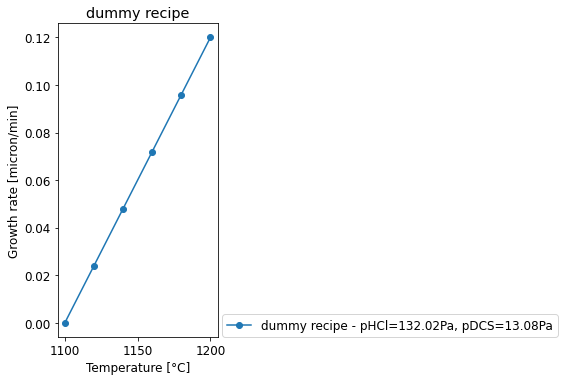

In [61]:
# Initialisation of figure and arrays of physical quantities.

plt.figure(figsize=(8,10))
Tlist_exp={}
gr_exp={}
sccm_tot={}
pH2_exp={}
pHCl_exp={}
pDCS_exp={}
Label={}
Title={}

#This loop computes grow rates (gr_exp) and partial pressures of gasses inside the chamber, i.e. pH2_exp, pHCl, pDCS_exp
# for every experiment reported in the database. It plots the growth rates as a function of the temperature [°C].

for experiment in calibranda_ST:
    # Computation
    process=database_ST[database_ST['Label']==experiment] #selection of lines associated to the experiment of the loop.
    Tlist_exp[experiment]=list(process.iloc[:]['Temperature_celsius'].astype(float)) #selection of temperature list.
    gr_exp[experiment]=list(process.iloc[:]['grown_thickness_micron']/process.iloc[:]['time_s']*60) #computation of the growth rates values [micron/min]
    sccm_tot[experiment]=list(process.iloc[:]['sccm_H2']+process.iloc[:]['sccm_HCl']+process.iloc[:]['sccm_DCS']) #computation of total sccm
    pH2_exp[experiment]=list(process.iloc[:]['sccm_H2']*process.iloc[:]['ptot_torr']*torr_to_Pa/sccm_tot[experiment]) #partial pressure of H2
    pHCl_exp[experiment]=list(process.iloc[:]['sccm_HCl']*process.iloc[:]['ptot_torr']*torr_to_Pa/sccm_tot[experiment]) #partial pressure of HCL
    pDCS_exp[experiment]=list(process.iloc[:]['sccm_DCS']*process.iloc[:]['ptot_torr']*torr_to_Pa/sccm_tot[experiment]) #partial pressure of DCS
    # Plotting
    Label[experiment]='dummy recipe'
    Title[experiment]='dummy recipe'
    plt.subplot(212)
    plt.plot(Tlist_exp[experiment], gr_exp[experiment], 'o-', 
             label=str(Label[experiment])+' - pHCl={}Pa, pDCS={}Pa'.format(round(pHCl_exp[experiment][0],2),round(pDCS_exp[experiment][0],2)))
    plt.title(Title[experiment])
    plt.xlabel('Temperature [°C]')
    plt.ylabel('Growth rate [micron/min]')
    plt.legend(loc=(1.03,0), fontsize=12)
    
plt.tight_layout()
#plt.savefig('exp_data.pdf')
plt.show()

## 2 CANTERA solution to get equilibrium molecular composition in gas-phase starting from original recipe

### 2.1. Read species and reactions database

In [62]:
gas= ct.Solution('./cantera_database_MUNDFAB.xml')
gas()
print('number of gaseous species= ',gas.n_species)
print('number of gaseous reactions= ',gas.n_reactions)

For species Si2, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  74.01147672
	Value computed using high-temperature polynomial: 74.0386547703

For species Si2, discontinuity in s/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  32.881299760183126
	Value computed using high-temperature polynomial: 32.94888061232226

For species Si2H6, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  19.832788750000002
	Value computed using high-temperature polynomial: 19.905538027666665

For species Si2H6, discontinuity in s/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  49.54934633430382
	Value computed using high-temperature polynomial: 49.72144349849784

For species Si3H8, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  29.302814743333336
	Value computed using high-temperature polynomial: 2

### 2.2. Selection of recipe and temperature range to study with CANTERA  

In [89]:
explist = calibranda_ST[0:1] # might be an array of entries from database 
tempidx = slice(None) # all temperatures; might be a subset of temperatures
tempidx = np.arange(0,4) # all temperatures; might be a subset of temperatures

### 2.3. Function to solve gas phase kinetics with CANTERA

In [64]:
def solve_gas_phase_kinetics(gas, Tlist_C, sccm, P, xthr):
    """
    Returns equilibrium molar fraction (and corresponding chemical formula) of all species 
    in an ideal gas at pressure P having a molar fraction largest than xthr, 
    for a set of temperatures and precursors sccm.
    Based on Cantera.
    """
    
    # Initial molar fractions of precursors
    sccm_sum = np.sum(list(sccm.values())) # Sum of all sccm values
    X0={}                                  # Array of molar fraction of precursors
    for i in sccm:
        X0[i] = sccm[i]/sccm_sum           # Molar fraction of precursors
    print('Ptot  [Pa]: {} Pa'.format(P))
    print('X0: {} '.format(X0))
    print('Tlist [C]: {} -- {} \n'.format(np.amin(Tlist_C), np.amax(Tlist_C)))
    
    # Reduction of the number of species to limit the computational cost, only those containing our elements are included
    myelements = [] # Definition of elements involved
    for i in X0:
        myelements.extend(list(gas.species(i).composition.keys()))
    myelements = list(set(myelements))
    print(myelements)    
    myspecies = [] # Definition of species involved
    for i in gas.species():
        if all(item in myelements for item in list(i.composition.keys())):
            myspecies.append(i)
    myspecies_names = [s.name for s in myspecies]
    print(myspecies_names)  
    myreactions = [] # Definition of reactions involved
    for r in gas.reactions():
        react_spec = list(r.reactants.keys())+list(r.products.keys())
        if set(np.char.lower(react_spec)).issubset(set(np.char.lower(myspecies_names))):
            myreactions.append(r)
    
    mygas = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                  species=myspecies, reactions=myreactions)  #Definition of the gas containing only species, elements and whom potentially gives rise only to reactions specified
    mygas()
    print('Total # species:', mygas.n_species)
    print('Total # reactions:', mygas.n_reactions)
    
    # Steady-state solution as a temperature function
    XT = np.zeros([len(Tlist_C), mygas.n_species]) #X(T) vs temperature for every gaseous specie
    for j,T in enumerate(Tlist_C):     
        mygas.TPX = T+celsius_to_K, P, X0 # Set thermodynamical variables
        mygas.equilibrate("TP", max_steps=10000, log_level=0) # Set the chemical equilibrium for fixed temperature and pressure
        XT[j] = np.array(mygas.X) # Store X(T) of each specie
    print('\n')

    # Molar fraction filter (with molar fraction filter, xthr)
    XTxthr = [] # Filtered molar fractions
    specnames_xthr = []
    for i in range(mygas.n_species):
        if np.any(XT[:,i]-xthr > 0): # Condition for filtering
            XTxthr.append(XT[:,i])
            specnames_xthr.append(mygas.species_names[i])
    XTxthr = np.array(XTxthr) # Filtered molar fractions
    specnames_xthr = np.array(specnames_xthr) # Filtered species

    # Sort molar fraction (XTxthr) in descending order (with associated specnames_xthr_sorted)
    XTxthr_sorted = np.array(sorted(XTxthr, key=lambda x: -x[0]))
    specnames_xthr_sorted = np.array(sorted(zip(specnames_xthr, XTxthr), key=lambda x: -x[1][0]), dtype=object)[:,0]

    return XTxthr_sorted, specnames_xthr_sorted, mygas

### 2.4 Definition of threshold for molar fractions obtained with CANTERA 

All molecules obtained with CANTERA whose molar fraction is below this threshold won't be considered in the model  

In [65]:
xthr = 2e-3 

### 2.5 Solution of kinetic-gas model using input precursors and relative sccm for every process selected above


 Experiment: Exp1
Ptot  [Pa]: 1466.542 Pa
X0: {'H2': 0.9010543390105434, 'SiH2Cl2': 0.008921330089213302, 'HCl': 0.09002433090024331} 
Tlist [C]: 1100.0 -- 1200.0 

['Cl', 'Si', 'H']
['Cl', 'Cl2', 'H', 'HCl', 'H2', 'Si', 'SiCl', 'SiCl2', 'SiCl3', 'SiCl4', 'SiH', 'SiHCl3', 'SiH2', 'SiH2Cl2', 'SiH3', 'SiH3Cl', 'SiH4', 'Si2', 'Si3', 'H2SiSiH2', 'H3SiSiH', 'Si2H6', 'Si3H8', 'SiHCl']
For species Si2, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  74.01147672
	Value computed using high-temperature polynomial: 74.0386547703

For species Si2, discontinuity in s/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  32.881299760183126
	Value computed using high-temperature polynomial: 32.94888061232226

For species Si2H6, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  19.832788750000002
	Value computed using high-temperature polynomial: 19.905538027666665

For species

<Figure size 864x288 with 0 Axes>

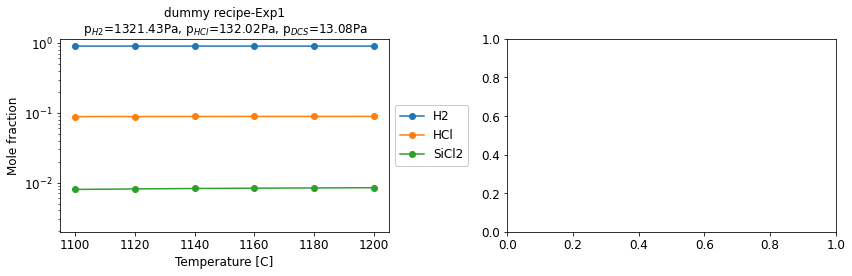

Gaseous species=  [array(['H2', 'HCl', 'SiCl2'], dtype=object)]
X(T) for each gaseous specie=  [array([[0.90283794, 0.9026448 , 0.90249164, 0.90236688, 0.90226178,
        0.90216964],
       [0.08828624, 0.08847113, 0.08861321, 0.08872347, 0.08880995,
        0.08887847],
       [0.00799874, 0.00814126, 0.00825354, 0.00834246, 0.00841324,
        0.00846978]])]


In [66]:
# Molar fractions vs temperature plot settings
plt.rcParams.update({'font.size': 12})
plt.figure()
plt.rcParams["figure.figsize"] = [12, len(calibranda_ST)*4]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(math.ceil(len(calibranda_ST)/2), 2)

# Solution of kinetic-gas model for every experiment
xx, xx_names, gas_reduced = [],[],[] # Initialization of X(T), Species(T) arrays and Gas object

for j,experiment in enumerate(explist):  # Loop over experiments
    print('\n Experiment:', experiment)
    
    ###################################
    ## Definition of process conditions
    process = database_ST[database_ST['Label']==experiment]
    Ptot = process.iloc[:]['ptot_torr'].values[0] * torr_to_Pa # Pa
    mytemperatures = np.array(Tlist_exp[experiment])[tempidx] # Celsius    
    sccm = {'H2': pH2_exp[experiment][0]/Ptot, 'SiH2Cl2': pDCS_exp[experiment][0]/Ptot, 'HCl': pHCl_exp[experiment][0]/Ptot}
    ###################################

    ## Solution of kinetic-gas model from defined function
    xx_j, xx_names_j, gas_reduced_j = solve_gas_phase_kinetics(gas=gas, Tlist_C=mytemperatures, \
                                                         sccm=sccm, P=Ptot, xthr=xthr)
    xx.append(xx_j)
    xx_names.append(xx_names_j)
    gas_reduced.append(gas_reduced_j)
    
# X(T) plot for all involved species
    axes = axes.ravel()
    for xname, x in zip(xx_names_j, xx_j):
        axes[j].semilogy(mytemperatures, x, 'o-', label=xname)
        print('{:10s}\t{:.2e} -- {:.2e}'.format(xname, x.min(), x.max()))    
    titlestring = f'{Label[experiment]}-{experiment}\n \
p$_{{H2}}$={pH2_exp[experiment][0]:.2f}Pa, \
p$_{{HCl}}$={pHCl_exp[experiment][0]:.2f}Pa, \
p$_{{DCS}}$={pDCS_exp[experiment][0]:.2f}Pa'
    axes[j].set_title(titlestring, fontsize=12)
    leg=axes[j].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    leg.get_frame().set_alpha(1)
    axes[j].set_ylabel('Mole fraction')
    axes[j].set_xlabel('Temperature [C]')
    axes[j].set_ylim([0.99*xthr, None])
        
plt.tight_layout()
plt.savefig('CANTERA_results.pdf')
plt.show()

print('Gaseous species= ', xx_names)
print('X(T) for each gaseous specie= ', xx)

## 3. Analytical model for growth rate prediction starting from equilibrium gas-phase precursors obtained with CANTERA

Herein, we describe the theoretical principles of the model used for the Si deposition on Si (100) from $\mathrm{SiH_2Cl_2 + H_2 + HCl}$ and the subsequent epitaxial growth of a silicon substrate within a chemical vapor deposition (CVD) chamber. 
The model, based on Ref. Coon1993., was modified according to the equilibrium gas phase calculations by Cantera (at the ST temperature range all DCS is converted to SiCl2. SiCl2,HCl and of course H2 are the only gaseous species inside the chamber).

The following simplified reaction sequence is used:

\begin{equation*}
\text{Si}\text{H}_2\text{Cl}_2(\text{g}) \longrightarrow \text{Si}\text{Cl}_2(\text{g}) + \text{H}_2(\text{g})
\label{eq:1} \tag{1}
\end{equation*}

\begin{equation*}
\text{Si}\text{Cl}_2(\text{g}) \rightleftharpoons \text{Si}\text{Cl}_2(\text{phys})
\label{eq:2} \tag{2}
\end{equation*}

\begin{equation*}
\text{Si}\text{Cl}_2(\text{phys}) + 2\text{db} \rightleftharpoons  \text{Si}(\text{a}) + 2\text{Cl}(\text{a})
\label{eq:3} \tag{3}
\end{equation*}

\begin{equation*}
\text{H}_2(\text{g}) + 2\text{db} \rightleftharpoons  2\text{H}(\text{a}) 
\label{eq:4} \tag{4}
\end{equation*}

\begin{equation*}
\text{HCl}(\text{g}) + 2\text{db} \rightleftharpoons  \text{H}(\text{a}) + \text{Cl}(\text{a}) 
\label{eq:5} \tag{5}
\end{equation*}

What is s, what is theta? 

Assuming second-order adsorption/desorption (dissociative/recombinative) of SiCl2, HCl and H2 (there are supporting Refs.),
reactions $\eqref{eq:1}$-$\eqref{eq:5}$ lead to the following system of coupled differential equations:

\begin{equation*}
\frac{\mathrm{d}\Theta_H}{\mathrm{d}t} = 2s_\mathrm{H_2} F^*_\mathrm{H_2} + s_\mathrm{HCl} F^*_\mathrm{HCl} - 2k_{\text{H}_2}\Theta^2_{\text{H}} - k_{\text{HCl}}\Theta_{\text{Cl}}\Theta_{\text{H}}
\label{eq:6} \tag{6}
\end{equation*}

\begin{equation*}
\frac{\mathrm{d}\Theta_{Cl}}{\mathrm{d}t} = 2s_\mathrm{SiCl_2} F^*_\mathrm{SiCl_2} + s_\mathrm{HCl} F^*_\mathrm{HCl}  - 2k_{\text{SiCl}_2}\Theta^2_{\text{Cl}} - k_{\text{HCl}}\Theta_{\text{Cl}}\Theta_{\text{H}} 
\label{eq:7} \tag{7}
\end{equation*}

\begin{equation*}
\frac{\mathrm{d}\Theta_{Si}}{\mathrm{d}t} = s_\mathrm{SiCl_2}  F^*_\mathrm{SiCl_2} - k_{\text{SiCl}_2}\Theta^2_{\text{Cl}}
\label{eq:8} \tag{8}
\end{equation*}

where $k_\mathrm{i}=A_i e^{-Ed_i/\mathrm{k_b}T}$ and $F^*_\mathrm{i}=\frac{p^*_i}{\sqrt{2 \pi M_iRT}}$. The star denotes that the pressure values (and equivalent impingement fluxes) refer to the gas-phase equilibrium values in the mixture (calculated from the atom fractions outputs by Cantera). 

As a first approximation, Eq. $\eqref{eq:8}$ is proportional to the Si growth rate, being the difference between the $\mathrm{SiCl_2}$ adsorption and desorption rate.

The reactive sticking coefficients $s_i$ for a precursor $i$ is a function of the surface coverage:

\begin{equation*}
s_i = s^0_i \Theta_{\text{db}}
\label{eq:12a} \tag{12a}
\end{equation*}

being $s^0_i$ the temperature-dependent initial sticking coefficients and $\mathrm{\Theta^{sat}_i}$ the saturation coverage of $i$. In the hypothesis of precursor-mediated adsorption (see Refs. 43,44 by Coon1992), $s^0_i$ can be written as:

\begin{equation*}
s^0_{i}= \frac{\alpha_i}{1+\beta_i \exp{\left[-\epsilon_i/RT \right]}}
\label{eq:13} \tag{13}
\end{equation*}

where $\alpha_i$, $\beta_i=k_{di}^0/k_{ri}^0$ and $\epsilon_i=E_{di}-E_{ri}$ are $i$-dependent constants.

The values for $s_\mathrm{SiH_2Cl_2}$ were reported by Coon et al. (1993) and are strictly valid for $T$ between 300 and 500 K (but assumed by the authors to be valid also between 923 and 1523K). 
The other $s_i$ (namely, the initial values $s^0_i$) must be inferred from elsewhere in the literature or from our previous calibration (for the case of H2). 
Notice that $\Theta_\text{sat}$ should take different values depending on $i$, since the saturation coverage depends both on the species (e.g., H vs Cl) and on the precursor for a given species (e.g. $\mathrm{HCl}$ vs $\mathrm{Cl2}$ vs $\mathrm{SiH_2Cl_2}$).  
According to Coon (1992,1993), at high temperatures (i.e., low H coverage) the chlorine saturation coverage $\mathrm{\Theta^{sat}_{Cl}}$ is similar to the dangling bond density of the grown surface $\mathrm{\Theta^{tot}_{db}}$ (which depends on the surface orientation). This tells us nothing about the Cl saturation coverage from $\mathrm{HCl}$, but we can assume it is equal because both HCl and DCS release the same ratio of Cl:H. 

As a first approximation we can assume that H and Cl both saturate when they form a monolayer, irrespective of the precursor, and that the total coverage saturates at 1 (coinciding with the surface density of dangling bonds for a given surface orientation): 

\begin{equation*}
\mathrm{\Theta_{sat}= \Theta^{tot}_{db} =\Theta_{Cl} + \Theta_{H} + \Theta^{free}_{db}}
\label{eq:14} \tag{14}
\end{equation*}

At equilibrium conditions, a steady state is stablished. assuming $\mathrm{\frac{d \Theta_{Cl}}{d t}}=0$ (Eq. 6) and $\mathrm{\frac{d \Theta_{H}}{d t}}=0$ (Eq. 7), coverage concentrations for hydrogen and chlorine satisfy the following set of algebric equations (Eqs. 9,10):

\begin{equation*}
\mathrm{
2k_{SiCl_2} \Theta^2_{Cl} + k_{HCl}\Theta_{Cl}\Theta_{H} - \left( 2s_{SiCl_2} F^*_{SiCl_2} + s_{HCl} F^*_{HCl} \right) = 0
}
\label{eq:9} \tag{9}
\end{equation*}

\begin{equation*}
\mathrm{
2k_{H_2} \Theta^2_{H} + k_{HCl}\Theta_{H}\Theta_{Cl} - \left( 2s_{H_2} F^*_{H_2} + s_{HCl} F^*_{HCl}  \right) = 0
}
\label{eq:10} \tag{10}
\end{equation*}

According to this model, $d\Theta_{Si}/dt$ is proportional to the Si growth rate, by a factor equal to the inverse of the density of the material, $\rho_{Si}^{at}=5.02\times10^{28} m^{-3}$. Hence, the growth rate can be calculated by solving the system of the previous two algebraic equations, substituting $\Theta_{H}$ and $\Theta_{Cl}$ into the differential equations for the surface coverage and dividing by $\rho_{Si}^{at}$.

### Calibration parameters (for both analytical model and the following KMC calculation)

In [67]:
theta_db = {'100':6.78e18, '111':1.1e18} #[m-2] #dangling bond densities of Si surface #(111) from coon1993; (100) from Gao1993 (from HCl chemisorption) 
theta_sat = theta_db['100'] #[m-2] # saturation coverage: assumption justified by high temperatures, otherwise must be modified!

#All parameters given below should be in eV
calibration = {
# Energy barrier (absolute value) for deposition of Si in a site with coor 1, 2 or 3:
'Edep': {'Si': [0]*3}, # DO NOT TOUCH (ENSURES CLEAN FLAT GROWTH WITHOUT COV)
# Energy barrier (absolute value) for evaporation of Si from a site without H neighbours with coor 1, 2 or 3:
'Eev': {'Si': np.asarray([-0.4, 0.3, 1.1])}, # DO NOT TOUCH (ENSURES CLEAN FLAT GROWTH WITHOUT COV)
# Energy barrier (absolute value) for absorption of H in a site with coor 1, 2 or 3:
'Eabs': {'Cl': [0]*3, 'H': [0]*3}, # deltaGR =  micron/min  
#Energy barrier (with minus sign) for desorption of H from a site with coor 1, 2 or 3:
'Edes': {'Cl': np.asarray([0, 0, 0]), 'H': np.asarray([0, 0, 0])},
# Perturbation to the energy barrier for evaporation of a Si with coverage neighbours 
'deltaE': {'H': np.asarray([0, 0, 0]), 'Cl': np.asarray([0, -0.5, 0])}, # (barrier is lowered if to Si detaches as SiCl2!)
# Parameters for s0, used in attachment and absorption (dict, one entry per molecule)
'alpha': {'SiCl2':ct.avogadro*1e-3 * 0.434959,'H2':ct.avogadro*1e-3 * 0.0160521, 'HCl':ct.avogadro*1e-3 * 0.0450889}, #non-dimensional
'kd0kr0ratio': {'SiCl2':600,'H2':1200000000, 'HCl':8400000}, #non-dimensional
'EdminusEr': {'SiCl2':0.1647809, 'H2':1.57, 'HCl':1.6}, #eV
# Parameters for kevap, used in detachment and desorption (dict, one entry per molecule)
'kevap_A': {'H2': 0.0002395341, 'HCl': 0.0065806075, 'SiCl2': 8.423177661e-06}, #[m^2/s]  
'kevap_E': {'H2': 2.69, 'HCl': 3.12, 'SiCl2': 2.91}, #[eV]
# Global scaling factor, used to scale all events probabilities
'scalef': 2e-19/2.35328434/0.53194474  , 
'scalefcov': 2e-19/2.35328434/0.53194474   
}
# Print out calibration set 
for c in calibration.keys():
    print(c, calibration[c])

Edep {'Si': [0, 0, 0]}
Eev {'Si': array([-0.4,  0.3,  1.1])}
Eabs {'Cl': [0, 0, 0], 'H': [0, 0, 0]}
Edes {'Cl': array([0, 0, 0]), 'H': array([0, 0, 0])}
deltaE {'H': array([0, 0, 0]), 'Cl': array([ 0. , -0.5,  0. ])}
alpha {'SiCl2': 2.6193843228288402e+23, 'H2': 9.666800569359601e+21, 'HCl': 2.71531702513564e+22}
kd0kr0ratio {'SiCl2': 600, 'H2': 1200000000, 'HCl': 8400000}
EdminusEr {'SiCl2': 0.1647809, 'H2': 1.57, 'HCl': 1.6}
kevap_A {'H2': 0.0002395341, 'HCl': 0.0065806075, 'SiCl2': 8.423177661e-06}
kevap_E {'H2': 2.69, 'HCl': 3.12, 'SiCl2': 2.91}
scalef 1.597677326882467e-19
scalefcov 1.597677326882467e-19


### 3.1. Analytical prediction of growth rate and coverage

In [68]:
# Growth rate calculator
def gr_calculator(pH2, pHCl, pDCS, Tvalues, mp):
    """
    The equations implemented in this section need to be adapted depending on the results of Cantera
    pH2, pHCl, pDCS: partial pressures of molecules obtained with CANTERA [Pa]
    Tvalues: temperatures [K]
    mp: associated CVD process class in pymulskips. 
    It contains the calibration parameters entering all stiching coefficients and desorption rates. 
    """
    print('Input parameters for growth rate calculator:')
    print('pH2 [Pa]', pH2)
    print('pHCl [Pa]', pHCl)
    print('pDCS [Pa]', pDCS)
    print('temperatures [K]', Tvalues)
    print('')
    
    rho_atom = 5.02e28 #m-3 #atomic density of crystalline Silicon
    theta_sat_Cl, theta_sat_H = theta_sat, theta_sat
    
    # Limit of H-free precursors
    if np.all(pH2 < 1e-10) and np.all(pHCl < 1e-10): theta_sat_H = 0   # at * m-2 (> # surface dangling bonds)
    thCl0, thH0 = theta_sat_Cl, theta_sat_H   # at * m-2 (> # surface dangling bonds)
    
    #initial sticking coefficient (at coverage==0) - (see EqXXX):
    def s0(prec,temp): 
        return mp.calibration_params['alpha'][prec]/(1+mp.calibration_params['kd0kr0ratio'][prec] * math.exp(-(mp.calibration_params['EdminusEr'][prec])/(mp.kb_ev*temp))) #non-dimensional
    
    #sticking coefficient at coverage!=0 - (see EqXXX):
    def s(prec, temp, thCl, thH): 
        s = s0(prec, temp) * ( 1 - (thCl+thH) / theta_sat) #non-dimensional
        return s

    # kinetic desorption parameters - (see EqXXX):
    def kd(prec,temp):
        return mp.calibration_params['kevap_A'][prec]*math.exp(-mp.calibration_params['kevap_E'][prec]/(mp.kb_ev*temp))

    # precursor impingement rate - (see EqXXX):
    def flux(pressure,prec,temp):  #returns a float
        return pressure/pow(2*math.pi*(mp.precursor_masses[prec])*(mp.Rgas)*temp,0.5)


    def dthetaCl(thCl, thH, temp, pDCS, pHCl):
        dthetaCl = 2 * s('SiCl2', temp, thCl, thH) * flux(pDCS,'SiCl2', temp) \
                   + s('HCl', temp, thCl, thH) * flux(pHCl,'HCl', temp) \
                   - kd('HCl', temp) * thCl * thH \
                   - 2 * kd('SiCl2', temp) * thCl**2     # m-2 s-1

#         print('des Cl', kd('HCl', temp), \
#               thCl * thH, \
#               kd('HCl', temp) * thCl * thH, \
#               kd('HCl', temp) * thCl * thH + 2*kd('SiCl2', temp) * thCl**2)

        return dthetaCl 

    def dthetaH(thCl, thH, temp, pDCS, pHCl, pH2):
        dthetaH = 2 * s('H2', temp, thCl, thH) * flux(pH2, 'H2', temp) \
                  + s('HCl', temp, thCl, thH) * flux(pHCl, 'HCl', temp) \
                  - kd('HCl', temp) * thCl * thH \
                  - 2 * kd('H2', temp) * thH**2     # m-2 s-1

#         print('des H', kd('H2', temp), \
#               thH**2, \
#               2*kd('H2', temp) * thH**2, \
#               kd('HCl', temp) * thCl * thH + 2 * kd('H2', temp) * thH**2)

        return dthetaH 

    def dthetaSi(thCl, thH, temp, pDCS):
        dthetaSi = s('SiCl2', temp, thCl, thH) * flux(pDCS, 'SiCl2', temp) \
                   - kd('SiCl2', temp) * thCl**2   # m-2 s-1

        #print('ev si', kd('SiCl2', temp), thCl**2, kd('SiCl2', temp) * thCl**2)
        
        return dthetaSi 

    
    def gr(thCl, thH, temp, pDCS):    
        GR = (dthetaSi(thCl, thH, temp, pDCS) / rho_atom) *1e6*60  # micron/min
        return GR
    
    def equations(x, *args):
        thCl, thH = x
        temp = args[0]
        pDCS = args[1]
        pHCl = args[2]
        pH2 = args[3]
        return (dthetaCl(thCl, thH, temp, pDCS, pHCl), dthetaH(thCl, thH, temp, pDCS, pHCl, pH2))

    # Loop over T and get array of growth rate
    thCl = np.zeros(len(Tvalues))
    thH = np.zeros(len(Tvalues))
    rate = np.zeros(len(Tvalues))
    
    for i, T in enumerate(Tvalues):
        # Get coverages of H and Cl
        ((thCl[i], thH[i]), _,iout,msg) =  fsolve(func=equations, x0=(thCl0, thH0), args=(T, pDCS[i], pHCl[i], pH2[i]), full_output=True)
        if iout != 1:
            print('fsolve warning', iout, ':', msg)
        # Compute growth rate
        rate[i] = gr(thCl[i], thH[i], T, pDCS[i])
    
    return rate, thCl/theta_sat, thH/theta_sat

In [69]:
# Compute growth rate
gr_theo, thCl, thH = {}, {}, {}
for j,experiment in enumerate(explist):
    process = database_ST[database_ST['Label']==experiment]
    Ptot = process.iloc[:]['ptot_torr'].values[0] * torr_to_Pa
    mytemperatures = np.array(Tlist_exp[experiment])[tempidx] + celsius_to_K # K
    
    Ppart = dict(zip(xx_names[j], xx[j][:,0]*Ptot))
    process_data = {'substrate': 'Si', 'precursors': xx_names[j], \
                    'temperature': mytemperatures[0], 'partial_pressures': Ppart}
    
    cvdclassANALYTICAL = mproc.CVD(process_data, calibration_params=calibration, gas=gas_reduced[j])
    
    # Ensure that H2, HCl and SiCl2 are always defined
    xxtmp = np.copy(xx[j])
    xxtmp_names = np.copy(xx_names[j])
    for i,spec in enumerate(['H2','HCl','SiCl2']): 
        if not spec in xx_names[j]:
            xxtmp_names = np.append(xxtmp_names, [spec], axis=0)
            xxtmp = np.append(xxtmp, [[0]*len(xx[j][0])], axis=0)
    gr_theo[experiment], thCl[experiment], thH[experiment] = \
                    gr_calculator(Tvalues = mytemperatures, mp=cvdclassANALYTICAL, \
                    pH2  = xxtmp[xxtmp_names=='H2'][0]*Ptot, \
                    pHCl = xxtmp[xxtmp_names=='HCl'][0]*Ptot, \
                    pDCS = xxtmp[xxtmp_names=='SiCl2'][0]*Ptot )  


Reading input from provided dictionary
lattice parameter for substrate: 5.431019241193291e-10
Using cantera equilibrium major species as precursors:
 ['H2' 'HCl' 'SiCl2']
*** Initializing CVD process for Si substrate with precursors ['H2' 'HCl' 'SiCl2']
mass 			--> Substrate Mass [Kg/mol]: 0.028085000000000002
rho 			--> Substrate Density [Kg/m^3]: 2329
rho_surf 		--> Substrate Surface density [Kg/m^2]: 1.2648843812739175e-06
temp 			--> Substrate temperature [K]: 1373.15
precursor_masses 	--> Precursor Masses [kg/mol]:
 {'H2': 0.002016, 'HCl': 0.036458000000000004, 'SiCl2': 0.09898500000000002}
partial_pressures 		--> Precursors partial pressures [Pa]:
 {'H2': 1324.0497622110393, 'HCl': 129.4754758080002, 'SiCl2': 11.730495316166401}
listcry 		--> Crystalline species in the substrate: ['Si']
listcryZ 		--> Atomic number of Crystalline species in the substrate: [14]
listcov 		--> Coverage species: ['Cl', 'H']
listcovZ 		--> Atomic number of coverage species: [17, 1]
KMC_sf 			--> Subst

GR EXP [0.    0.024 0.048 0.072 0.096 0.12 ]


<Figure size 864x288 with 0 Axes>

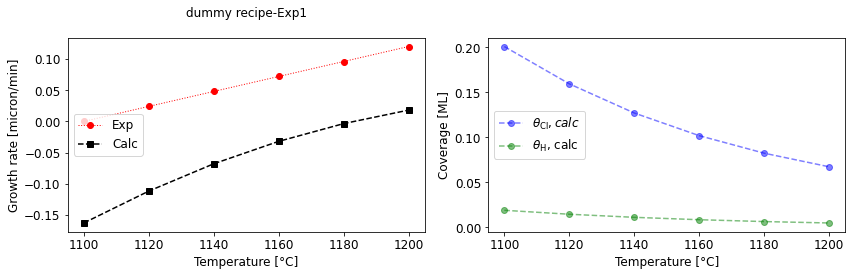

In [73]:
#======================================  PLOT  =========================================================================
plt.rcParams.update({'font.size': 12})
plt.figure()
plt.rcParams["figure.figsize"] = [12, len(explist)*4]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(len(explist), 2)
axes = axes.ravel()
row = 0
for j,experiment in enumerate(explist):
    mytemperatures = np.array(Tlist_exp[experiment])[tempidx]  # Celsius
    
    #--------- here the plots of growth rate ---------------------------------------
    axes[row+j].plot(Tlist_exp[experiment], np.asarray(gr_exp[experiment]),'ro:', lw=1, label='Exp')
    axes[row+j].plot(mytemperatures, gr_theo[experiment], 'k--s', label='Calc')
    
    print('GR EXP', np.asarray(gr_exp[experiment]))
    
    axes[row+j].legend(loc='center left', fontsize=12)
    axes[row+j].set_xlabel('Temperature [°C]')
    axes[row+j].set_ylabel('Growth rate [micron/min]')
    titlestring = f'{Label[experiment]}-{experiment}\n '
    axes[row+j].set_title(titlestring, fontsize=12)
    
    #--------- here the plots of coverage ---------------------------------------
    # analytical
    axes[row+j+1].plot(mytemperatures[tempidx], thCl[experiment], '--o', c='b', alpha=0.5, label=r'$\theta_{\rm Cl}, calc$')
    axes[row+j+1].plot(mytemperatures[tempidx], thH[experiment], '--o', c='g', alpha=0.5, label=r'$\theta_{\rm H}$, calc')

    axes[row+j+1].legend(loc='center left', fontsize=12)
    axes[row+j+1].set_xlabel('Temperature [°C]')
    axes[row+j+1].set_ylabel('Coverage [ML]')
    
    #---------
    row += 1

plt.tight_layout()
plt.savefig('allprocesses.pdf')

## 4. MulSKIPS KMC model 

### 4.1. Compile MulSKIPS

In [74]:
execpath = os.getcwd()+'/mulskips-source' # Put mulskips-source in current directory
lenx, leny, lenz = 240, 240, 760 # Box size --> KMC super-lattice units (0.543/12 nm)
setuprun.setup_mulskips_src(execpath, lenx, leny, lenz) # it will rerecompile if needed

Compiling MulSKIPS with box size: 240 x 240 x 760
Directory changed to: /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/mulskips-source

********************************** Starting MulSKIPS compilation **********************************
MulSKIPS:	rm ./modules/defdertype.o ./modules/defsystem.o ./modules/definitions.o ./initial/SetAPB.o ./initial/SetInvPC.o ./initial/SetInvPwAPB.o ./initial/SetNCSp.o ./initial/SetNCSpSi.o ./initial/SetAPBSym.o ./initial/SetInvP.o ./initial/SetInvPwOnlyCorSi.o ./initial/SetSiC3C.o ./initial/SetSiCSF.o ./initial/SetSiGex.o ./initial/SetSiC3Cww.o ./initial/SetSiC3Cwwaperture.o ./initial/SetSi.o ./initial/SetSiFINFET.o ./initial/SetCAD.o ./initial/SetT.o ./initial/SetAPBSymZimb1.o ./initial/SetInvPOff.o ./initial/SetInvPwOnlySiorC.o ./initial/SetTrenchSi.o ./initial/SetTrench.o ./initial/SetAPBSymZimb.o ./initial/SetInvPSi.o ./initial/SetNC.o ./inpout/FileClose.o ./inpout/GetOutputFileName.o ./inp

### 4.2. Setup and run Mulskips (this step could take some time, depending on the number of simulations)

In [75]:
for j,experiment in enumerate(explist):    

    process = database_ST[database_ST['Label']==experiment]
    Ptot = process.iloc[:]['ptot_torr'].values[0] * torr_to_Pa
    mytemperatures = np.array(Tlist_exp[experiment])[tempidx] + celsius_to_K # K
    
    for iT,T in enumerate(mytemperatures): # K
        runpath = 'Exp{}_T{}'.format(j+1,T)
        Ppart = dict(zip(xx_names[j], xx[j][:,iT]*Ptot))
        process_data = {'substrate': 'Si', 'precursors': xx_names[j], \
                        'temperature': T, 'partial_pressures': Ppart}
        
        cvdclass = mproc.CVD(process_data, calibration_params=calibration, gas=gas_reduced[j])
        
        # Conversion needed only in the KMC to ensure same units as in the analytical model
        cvdclass.calibration_params['kevap_A']['HCl'] *= 0.1*theta_sat**2 # thCl*thH   
        cvdclass.calibration_params['kevap_A']['H2'] *= 0.1*theta_sat**2 # thH**2         
        cvdclass.calibration_params['kevap_A']['SiCl2'] *= 0.1*theta_sat**2 # thCl**2  # gr >>  if this decreases 
        
        Nout = 7 # MIN 5!
        itermax = 14000000 # LARGE FOR GROWTH RATE ESTIMATE; SMALL FOR COVERAGE ESTIMATE
        setuprun.run_mulskips(execpath, runpath, Simulation='FS', mp=cvdclass, PtransZig=1.0, \
            ExitStrategy='Iter', IterMax = itermax, OutMolMol = int(itermax/Nout), \
            Seed_box=[240,0,0], RunType='R', IDUM=9117116, setup_only=False)        


Reading input from provided dictionary
lattice parameter for substrate: 5.431019241193291e-10
Using cantera equilibrium major species as precursors:
 ['H2' 'HCl' 'SiCl2']
*** Initializing CVD process for Si substrate with precursors ['H2' 'HCl' 'SiCl2']
mass 			--> Substrate Mass [Kg/mol]: 0.028085000000000002
rho 			--> Substrate Density [Kg/m^3]: 2329
rho_surf 		--> Substrate Surface density [Kg/m^2]: 1.2648843812739175e-06
temp 			--> Substrate temperature [K]: 1373.15
precursor_masses 	--> Precursor Masses [kg/mol]:
 {'H2': 0.002016, 'HCl': 0.036458000000000004, 'SiCl2': 0.09898500000000002}
partial_pressures 		--> Precursors partial pressures [Pa]:
 {'H2': 1324.0497622110393, 'HCl': 129.4754758080002, 'SiCl2': 11.730495316166401}
listcry 		--> Crystalline species in the substrate: ['Si']
listcryZ 		--> Atomic number of Crystalline species in the substrate: [14]
listcov 		--> Coverage species: ['Cl', 'H']
listcovZ 		--> Atomic number of coverage species: [17, 1]
KMC_sf 			--> Subst

KMC:	 CountCrystalOld       16490           0           0
KMC:	 diff   3972.0000000000000        0.0000000000000000        0.0000000000000000
KMC:	 xGesolid   1.0000000000000000        0.0000000000000000        0.0000000000000000
KMC:	 CountCov        2461         152           0
KMC:	 I00000005
KMC:	           0
KMC:	 Iter, Time, Site             10000000   2.1755967638640636              177           9         315
KMC:	 NatNvoidNad       81659           6        2417
KMC:	 SUM(CountCrystal)       24483
KMC:	 CountCrystal       24483           0           0
KMC:	 CountCrystalOld       20462           0           0
KMC:	 diff   4021.0000000000000        0.0000000000000000        0.0000000000000000
KMC:	 xGesolid   1.0000000000000000        0.0000000000000000        0.0000000000000000
KMC:	 CountCov        2917         191           0
KMC:	 I00000006
KMC:	           0
KMC:	 Iter, Time, Site             12000000   2.6043428106529540               45         195         333
KMC:	 NatNvoi

KMC:	 CountCrystalOld           0           0           0
KMC:	 diff   4360.0000000000000        0.0000000000000000        0.0000000000000000
KMC:	 xGesolid   1.0000000000000000        0.0000000000000000        0.0000000000000000
KMC:	 CountCov         374          39           0
KMC:	 I00000001
KMC:	           0
KMC:	 Iter, Time, Site              2000000  0.51438875156523367               15          45         261
KMC:	 NatNvoidNad       65556           1        2435
KMC:	 SUM(CountCrystal)        8301
KMC:	 CountCrystal        8301           0           0
KMC:	 CountCrystalOld        4360           0           0
KMC:	 diff   3941.0000000000000        0.0000000000000000        0.0000000000000000
KMC:	 xGesolid   1.0000000000000000        0.0000000000000000        0.0000000000000000
KMC:	 CountCov         713          79           0
KMC:	 I00000002
KMC:	           0
KMC:	 Iter, Time, Site              4000000   1.0171833706498796               39          87         267
KMC:	 NatNvoi

Number of evaporation probabilities:  19
DONE writing start.dat
DONE MulSKIPs setup. ETA: 0.01530766487121582 sec
The executable directory is /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/mulskips-source

********************************** Starting MulSKIPs **********************************
KMC:	 KMC box size:          240         240         760
KMC:	            ***** Simulating CVD *****
KMC:	 Crystal species (NCrystal=           1 ) --> Z:          14
KMC:	 Coverage species (NCov=           2 ) --> Z:          17           1
KMC:	 KMC Super-Lattice parameter (ang):   0.45250000000000001
KMC:	 Exit strategy: Iter
KMC:	 MaxIter:              14000000
KMC:	 OutMolMol:               2000000
KMC:	 IDUM     9117116
KMC:	 SaveFinalState flag is not "T": checkpoint file will  not be written.
KMC:	 SaveCoo flag is not "T": Coor file not stored
KMC:	 maxElines          19
KMC:	 numParticelle=      500000 Levels =          20 , Si

DONE MulSKIPs setup. ETA: 0.013018608093261719 sec
The executable directory is /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/mulskips-source

********************************** Starting MulSKIPs **********************************
KMC:	 KMC box size:          240         240         760
KMC:	            ***** Simulating CVD *****
KMC:	 Crystal species (NCrystal=           1 ) --> Z:          14
KMC:	 Coverage species (NCov=           2 ) --> Z:          17           1
KMC:	 KMC Super-Lattice parameter (ang):   0.45250000000000001
KMC:	 Exit strategy: Iter
KMC:	 MaxIter:              14000000
KMC:	 OutMolMol:               2000000
KMC:	 IDUM     9117116
KMC:	 SaveFinalState flag is not "T": checkpoint file will  not be written.
KMC:	 SaveCoo flag is not "T": Coor file not stored
KMC:	 maxElines          19
KMC:	 numParticelle=      500000 Levels =          20 , SizeTree =     1048575
KMC:	 Atoms,Voids,AdAtoms       61600     

Number of evaporation probabilities:  19
DONE writing start.dat
DONE MulSKIPs setup. ETA: 0.01654648780822754 sec
The executable directory is /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/mulskips-source

********************************** Starting MulSKIPs **********************************
KMC:	 KMC box size:          240         240         760
KMC:	            ***** Simulating CVD *****
KMC:	 Crystal species (NCrystal=           1 ) --> Z:          14
KMC:	 Coverage species (NCov=           2 ) --> Z:          17           1
KMC:	 KMC Super-Lattice parameter (ang):   0.45250000000000001
KMC:	 Exit strategy: Iter
KMC:	 MaxIter:              14000000
KMC:	 OutMolMol:               2000000
KMC:	 IDUM     9117116
KMC:	 SaveFinalState flag is not "T": checkpoint file will  not be written.
KMC:	 SaveCoo flag is not "T": Coor file not stored
KMC:	 maxElines          19
KMC:	 numParticelle=      500000 Levels =          20 , Si

RunType:  R
IDUM:  9117116
SaveFinalState:  False
SaveCoo:  False
Only generate start.dat and do not run:  False

Deposition energetics:
 [[0. 0. 0.]]
2.2614509498383014e+20 Si
Deposition probabilities: 
 [[36.13068908 36.13068908 36.13068908]]

Evaporation energetics:
 [[[[ 0.   0.   0.   0. ]
   [ 0.   0.   0.   0. ]
   [ 0.   0.   0.   0. ]
   [ 0.   0.   0.   0. ]]

  [[-0.4 -0.4 -0.4 -0.4]
   [-0.4 -0.4 -0.4  0. ]
   [-0.9 -0.9  0.   0. ]
   [-0.4  0.   0.   0. ]]

  [[ 0.3  0.3  0.3  0. ]
   [ 0.3  0.3  0.   0. ]
   [-0.2  0.   0.   0. ]
   [ 0.   0.   0.   0. ]]

  [[ 1.1  1.1  0.   0. ]
   [ 1.1  0.   0.   0. ]
   [ 0.   0.   0.   0. ]
   [ 0.   0.   0.   0. ]]]]
4.2910594499070216e+21 Si
Evaporation probabilities: 
 [[[[6.85572839e+02 6.85572839e+02 6.85572839e+02 6.85572839e+02]
   [6.85572839e+02 6.85572839e+02 6.85572839e+02 6.85572839e+02]
   [6.85572839e+02 6.85572839e+02 6.85572839e+02 6.85572839e+02]
   [6.85572839e+02 6.85572839e+02 6.85572839e+02 6.85572839e+02]]

  [

### 4.3. Growth rate and coverage analysis

There are 8 'undercoordinated' files available in /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15/I00000000.xyz
* WARNING: z range in xyz file is null or < bin size, so we directly average z column.
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15/I00000001.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15/I00000002.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15/I00000003.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15/I00000004.xyz
/mnt/c/Users/gaeta/Documents/CNR/proj

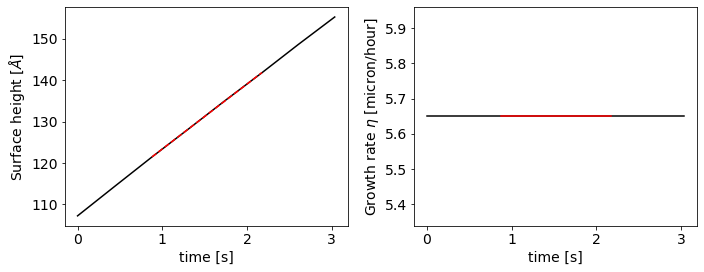

There are 8 'undercoordinated' files available in /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15/I00000000.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15/I00000001.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15/I00000002.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15/I00000003.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.15/I00000004.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1373.1

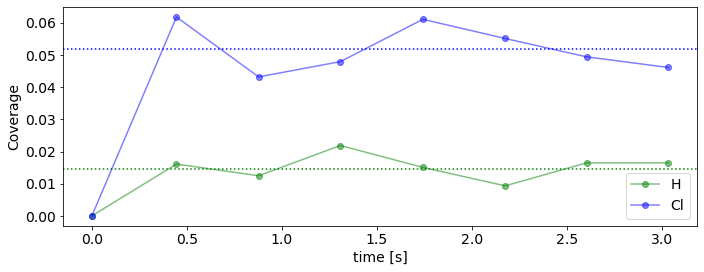

There are 8 'undercoordinated' files available in /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15/I00000000.xyz
* WARNING: z range in xyz file is null or < bin size, so we directly average z column.
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15/I00000001.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15/I00000002.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15/I00000003.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15/I00000004.xyz
/mnt/c/Users/gaeta/Documents/CNR/proj

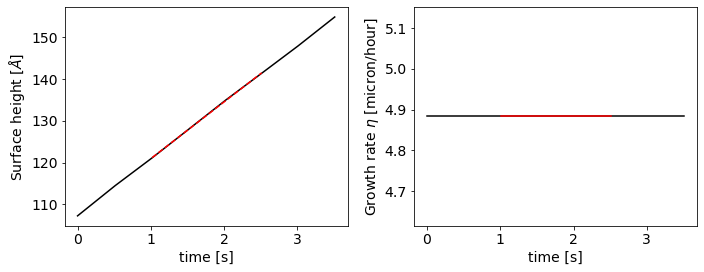

There are 8 'undercoordinated' files available in /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15/I00000000.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15/I00000001.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15/I00000002.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15/I00000003.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.15/I00000004.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1393.1

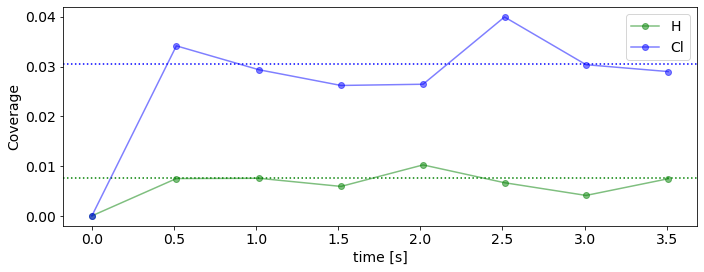

There are 8 'undercoordinated' files available in /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15/I00000000.xyz
* WARNING: z range in xyz file is null or < bin size, so we directly average z column.
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15/I00000001.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15/I00000002.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15/I00000003.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15/I00000004.xyz
/mnt/c/Users/gaeta/Documents/CNR/proj

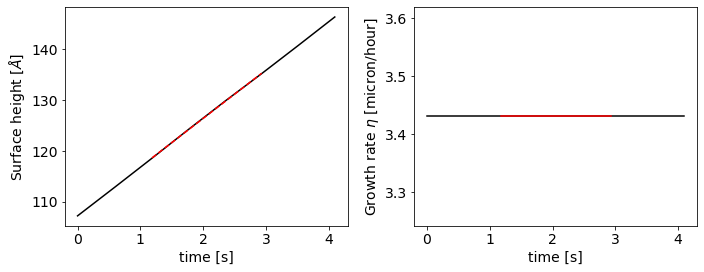

There are 8 'undercoordinated' files available in /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15/I00000000.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15/I00000001.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15/I00000002.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15/I00000003.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.15/I00000004.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1413.1

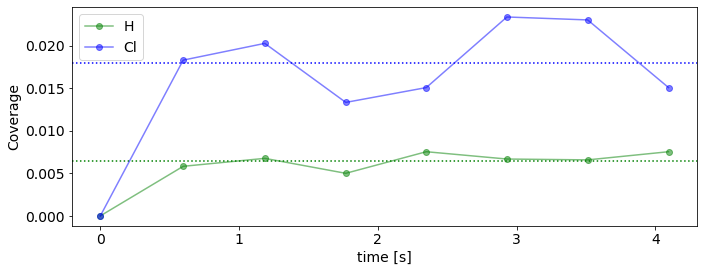

There are 8 'undercoordinated' files available in /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15/I00000000.xyz
* WARNING: z range in xyz file is null or < bin size, so we directly average z column.
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15/I00000001.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15/I00000002.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15/I00000003.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15/I00000004.xyz
/mnt/c/Users/gaeta/Documents/CNR/proj

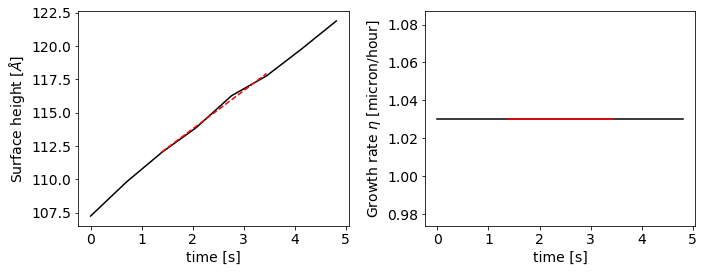

There are 8 'undercoordinated' files available in /mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15/I00000000.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15/I00000001.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15/I00000002.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15/I00000003.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.15/I00000004.xyz
/mnt/c/Users/gaeta/Documents/CNR/project_CVD_ST/articolo_CVD_Domenica/scripts_articolo_CVD/calib_CVD_ST_2023/ST_Exp1_T1433.1

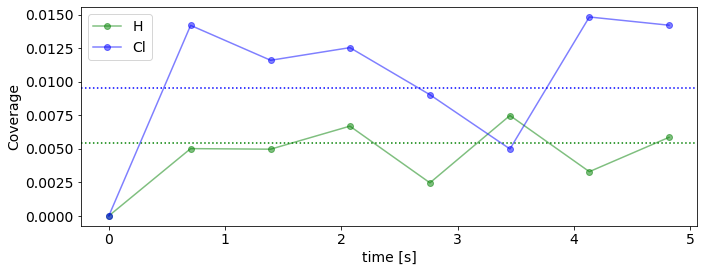

In [90]:
gr_KMC, thCl_KMC, thH_KMC = {}, {}, {}
for j,experiment in enumerate(explist):        
    mytemperatures = np.array(Tlist_exp[experiment])[tempidx] + celsius_to_K # K

    gr_KMC[experiment] = np.ones(len(mytemperatures))*1e5     # 1e5 is just to spot errors... 
    thCl_KMC[experiment] = np.ones(len(mytemperatures))*1e5   # 1e5 is just to spot errors...
    thH_KMC[experiment] = np.ones(len(mytemperatures))*1e5    # 1e5 is just to spot errors...
    for iT,T in enumerate(mytemperatures): 
        runpath = 'ST_Exp{}_T{}'.format(j+1,T)
        
        ## Analysis of epitaxial-growth substrate quality and defects
        gr_KMC[experiment][iT] = analyze.analyze_growth_rate(runpath, bin_size=5.0, \
                                surface_roughness=10.0, plotting=True, figname='fig-{}'.format(experiment), \
                                Nexclude=2, method='polyfit')
        data = analyze.analyze_coverage(runpath, plotting=True, figname='fig-{}'.format(experiment), Nexclude=2, mp=cvdclass)
        thCl_KMC[experiment][iT] = data['Cl']
        thH_KMC[experiment][iT] = data['H']

KMC [0.094154   0.08138468 0.05717808 0.01717267]
EXP [0.    0.024 0.048 0.072]


<Figure size 864x288 with 0 Axes>

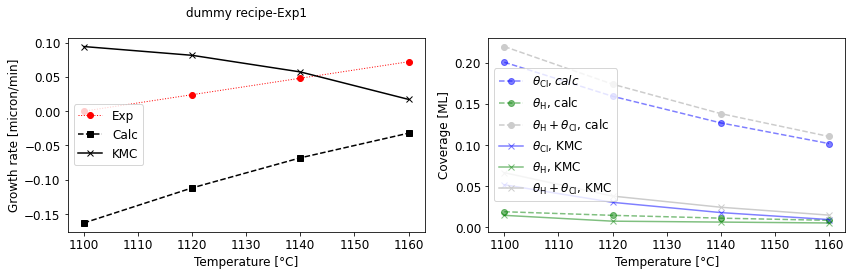

In [95]:
#======================================  PLOT  =========================================================================
plt.rcParams.update({'font.size': 12})
plt.figure()
plt.rcParams["figure.figsize"] = [12, len(explist)*4]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(len(explist), 2)
axes = axes.ravel()
row = 0
for j,experiment in enumerate(explist):
    mytemperatures = np.array(Tlist_exp[experiment])[tempidx]  # Celsius
    #--------- here the plots of growth rate ---------------------------------------
    axes[row+j].plot(np.asarray(Tlist_exp[experiment])[tempidx], np.asarray(gr_exp[experiment])[tempidx],'ro:', lw=1, label='Exp')
    axes[row+j].plot(mytemperatures, gr_theo[experiment][tempidx], 'k--s', label='Calc')
    axes[row+j].plot(mytemperatures, gr_KMC[experiment][tempidx]/60, 'k-x', label='KMC')
    print('KMC', gr_KMC[experiment][tempidx]/60)
    print('EXP', np.asarray(gr_exp[experiment])[tempidx])
    
    #print('KMC/EXP', (gr_KMC[experiment]/60 )/ np.asarray(gr_exp[experiment])[tempidx])
    
    axes[row+j].legend(loc='center left', fontsize=12)
    axes[row+j].set_xlabel('Temperature [°C]')
    axes[row+j].set_ylabel('Growth rate [micron/min]')
    titlestring = f'{Label[experiment]}-{experiment}\n ' 
    axes[row+j].set_title(titlestring, fontsize=12)
    
    #--------- here the plots of coverage ---------------------------------------
    # analytical
    axes[row+j+1].plot(mytemperatures, thCl[experiment][tempidx], '--o', c='b', alpha=0.5, label=r'$\theta_{\rm Cl}, calc$')
    axes[row+j+1].plot(mytemperatures, thH[experiment][tempidx], '--o', c='g', alpha=0.5, label=r'$\theta_{\rm H}$, calc')
    axes[row+j+1].plot(np.array(mytemperatures[tempidx]), thH[experiment][tempidx]+thCl[experiment][tempidx], '--o', c='0.8', label=r'$\theta_{\rm H}+\theta_{\rm Cl}$, calc')
    # KMC
    axes[row+j+1].plot(mytemperatures, thCl_KMC[experiment][tempidx], '-x', c='b', alpha=0.5, label=r'$\theta_{\rm Cl}$, KMC')
    axes[row+j+1].plot(mytemperatures, thH_KMC[experiment][tempidx], '-x', c='g', alpha=0.5, label=r'$\theta_{\rm H}$, KMC')
    axes[row+j+1].plot(mytemperatures, thH_KMC[experiment][tempidx]+thCl_KMC[experiment][tempidx], '-x', c='0.8', label=r'$\theta_{\rm H}+\theta_{\rm Cl}$, KMC')
    
    axes[row+j+1].legend(loc='center left', fontsize=12)
    axes[row+j+1].set_xlabel('Temperature [°C]')
    axes[row+j+1].set_ylabel('Coverage [ML]')
    
    #---------
    row += 1

plt.tight_layout()
plt.savefig('allprocesses.pdf')